In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_hcm = pd.read_csv('crawled_all_shops/data_hcm_final.csv')

C:\Users\Admin\AppData\Local\Temp\ipykernel_4508\2803367899.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_hcm = pd.read_csv('crawled_all_shops/data_hcm_final.csv')


# 1. Thống kê SL shop cào dc mỗi quận
dist, long_dist, lat_dist, cnt_shops 

<AxesSubplot: ylabel='District'>

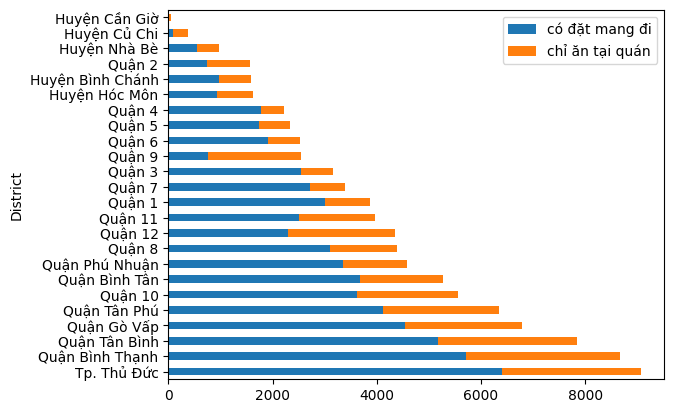

In [ ]:
count_shop_per_dist = data_hcm.groupby('District')['RestaurantId'].count().sort_values(ascending=False)
count_delivery_shop = data_hcm.groupby('District')['IsDelivery'].sum()
df = pd.merge(count_shop_per_dist, count_delivery_shop, how='outer', left_on='District', right_on='District').reset_index()
df.rename(columns={'RestaurantId': 'nShops'}, inplace=True)
df['no delivery'] = df['nShops'] - df['IsDelivery']
df = df.drop('nShops', axis=1).rename(columns={'IsDelivery': 'có đặt mang đi',
                                               'no delivery': 'chỉ ăn tại quán'})
# df
df.set_index('District').plot.barh(stacked=True)
# plt.figure(figsize=(15,10))
# ser.plot.barh()

Improve: dùng map Tableau

# 2. Tương quan

- Coi tương quan chung trước

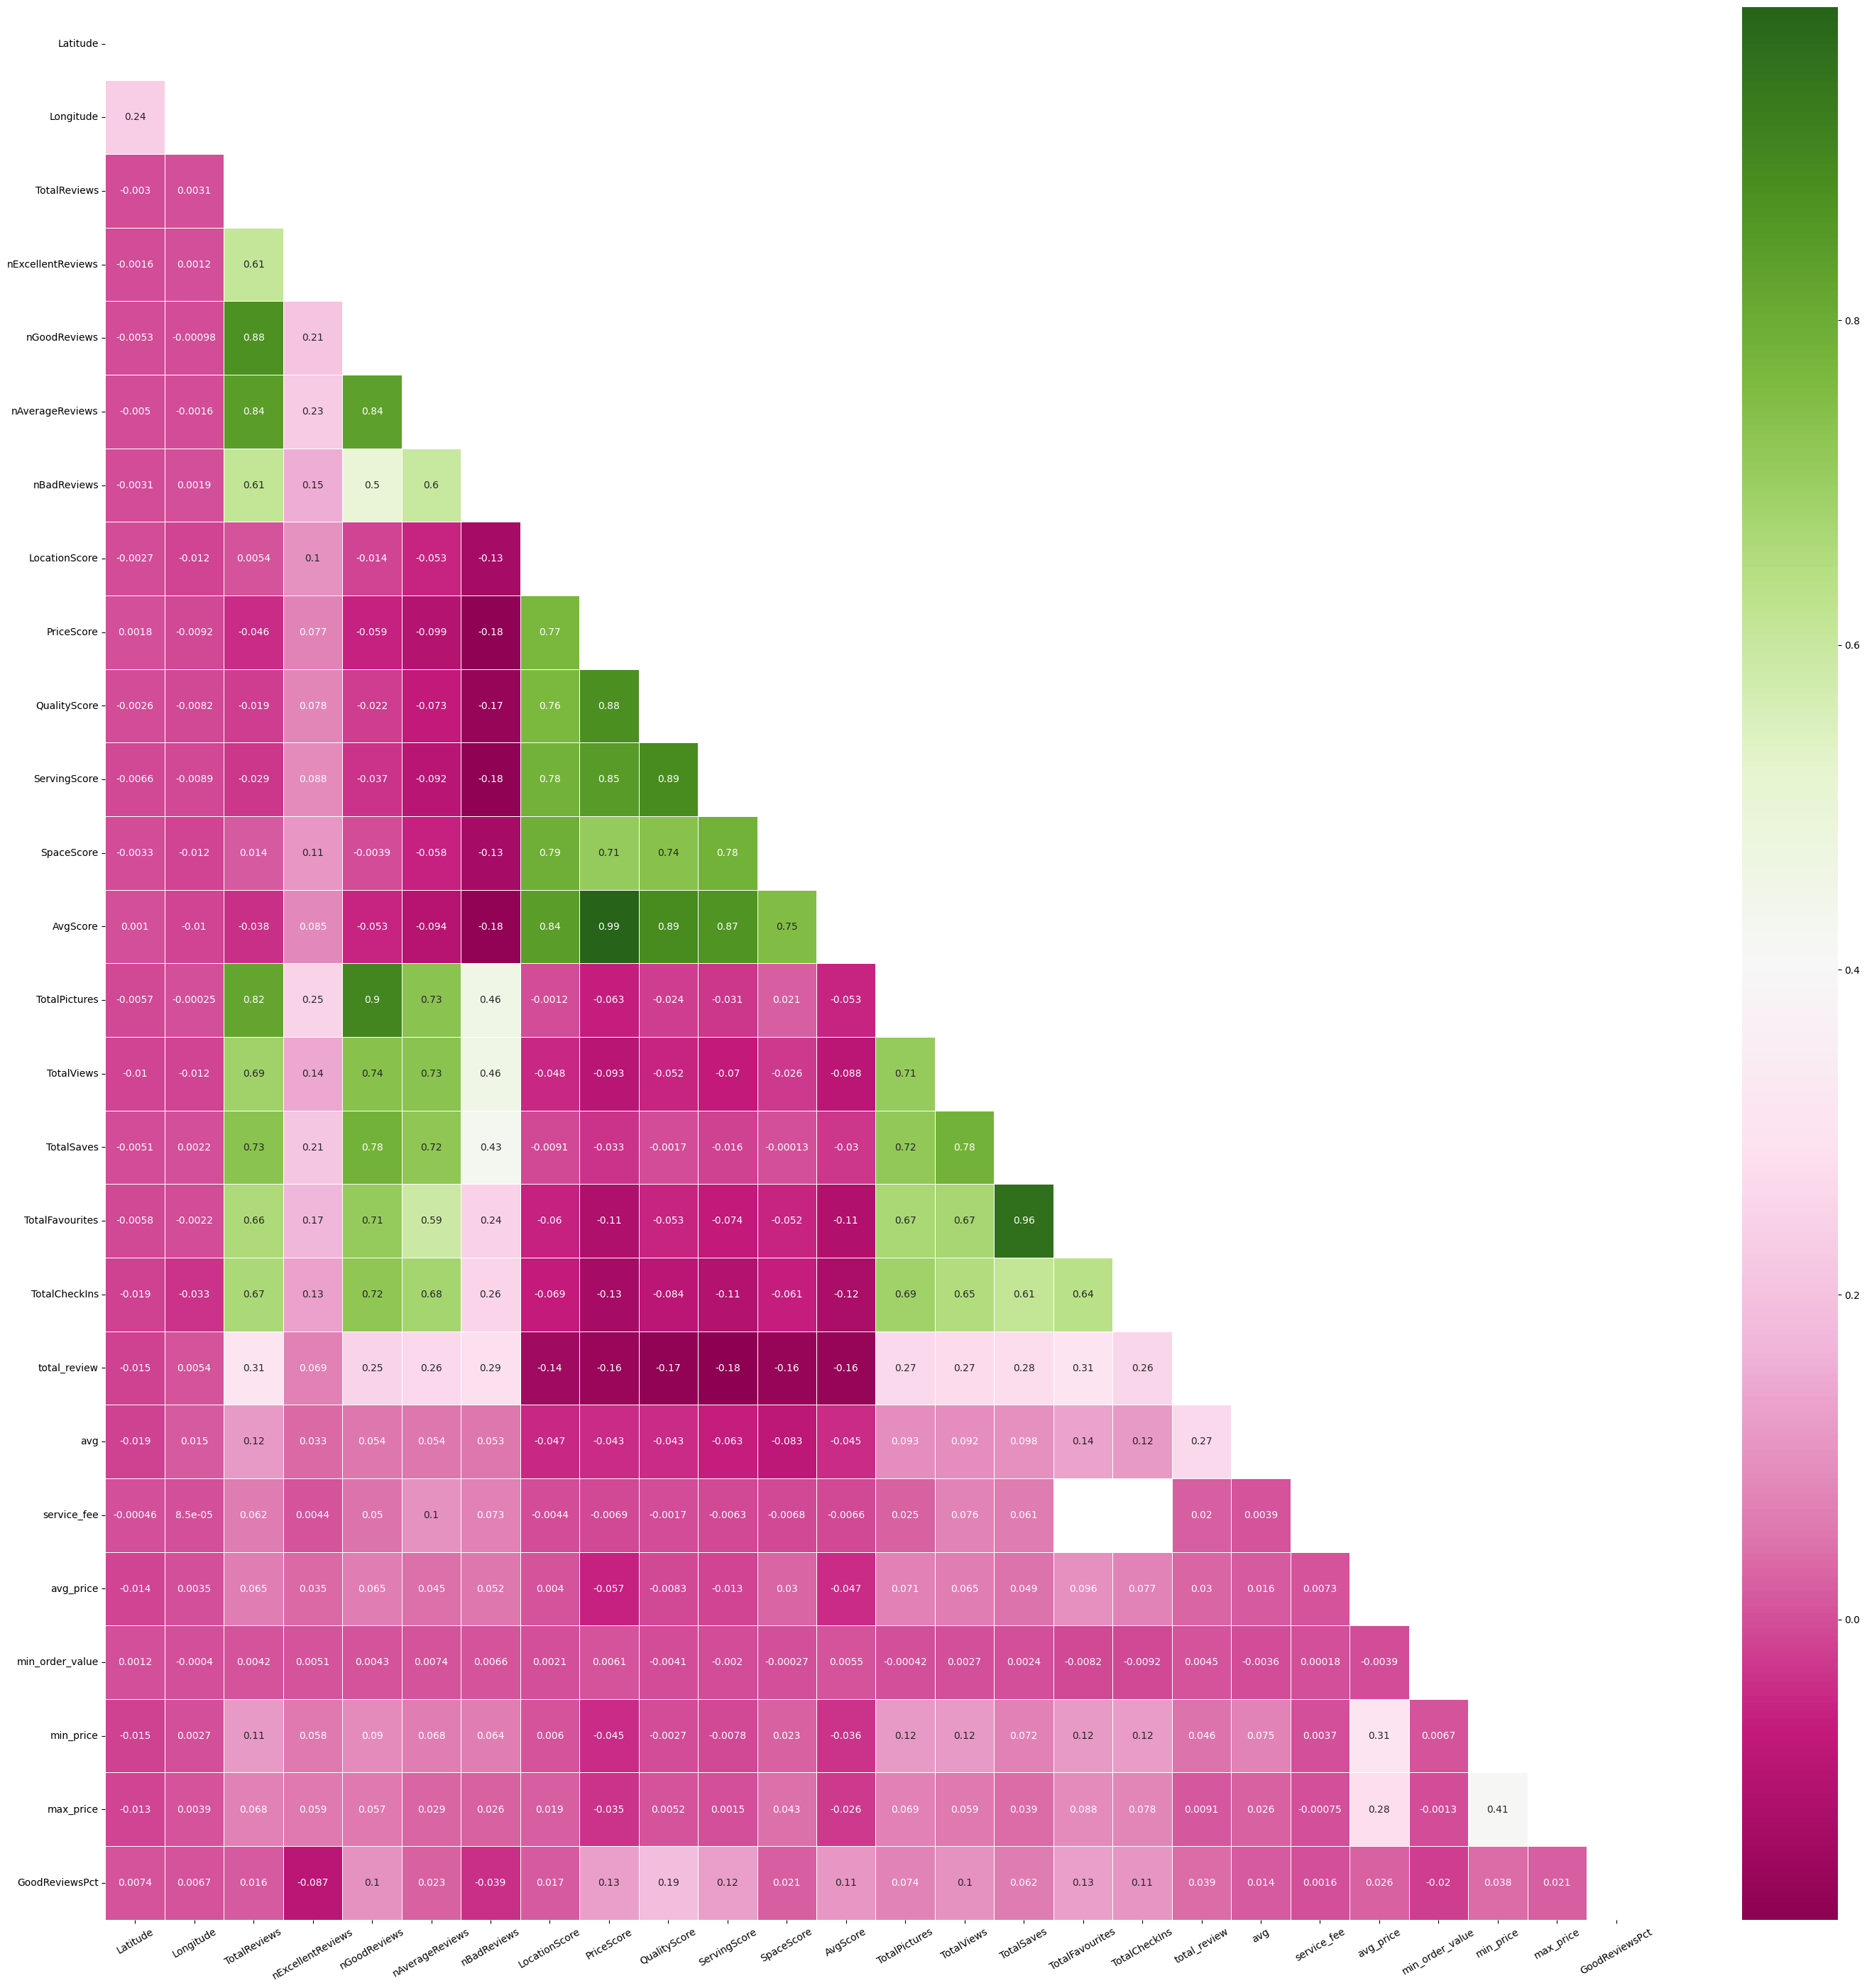

In [55]:
corr = data_hcm.select_dtypes([np.float64]).drop(['RestaurantStatus'], axis=1).corr()
plt.figure(figsize=(35,35))
matrix = np.triu(corr)
ax = sns.heatmap(corr, mask=matrix,
                annot=True,
                cmap="PiYG",
                linewidths=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);    
plt.savefig('correlation.png')            

Nếu coi 1 tương quan mạnh là tương quan có corr > 0.8 thì:
- nGoodReviews, nAverageReviews; TotalPictures tương quan dương với TotalReviews
- nAverageReviews, TotalPictures tương quan dương với nGoodReviews
- {Location,Price,Quality,Serving}Score tương quan dương với AvgScore
- TotalFavourites tương quan dương với TotalSaves

## 2.1. Tương quan giữa nGoodReviews & TotalReviews

Từ heatmap, ta thấy rằng trong n{Excellent,Good,Average,Bad}Reviews thì nGoodReview có tương quan mạnh nhất với TotalReviews

Text(0.5, 0, 'GoodReviewsPct')

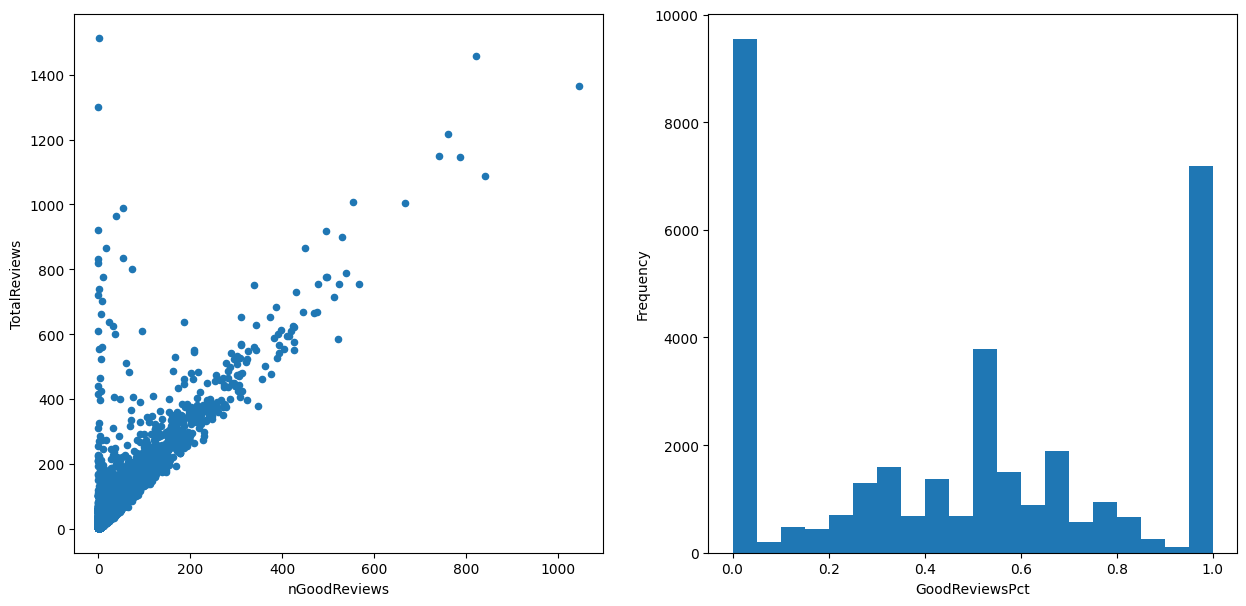

In [3]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
data_hcm.plot.scatter(x='nGoodReviews', y='TotalReviews', ax=ax[0])

# với từng quán trong các shops, nGoodReviews chiếm bnhiêu % so với tổng số Review từng quán
data_hcm['GoodReviewsPct'] = data_hcm['nGoodReviews'] / data_hcm['TotalReviews']
data_hcm['GoodReviewsPct'].plot.hist(bins=20, ax=ax[1])
ax[1].set_xlabel('GoodReviewsPct')

-> Đa phần các quán ăn thể hiện mối tương quan dương. 1 bộ phận nhỏ quán ăn thì không tuân theo đường tuyến tính này. Cần **kiểm tra độ tin cậy của mối tương quan này**, i.e. cần coi thử các review tốt thu thập từng quán có phải là các review chạy seeding không vì 1 vài quán có thể chạy hàng trăm seeding review để đẩy điểm trung bình của quán lên 


Cách thực hiện:
- Nest 4 distribution của n{Excellent,Good,Average,Bad}Reviews lại để coi đỉnh của 4 distribution phân bố như nào
- Rút trích từ khoá theo phương pháp TF-IDF theo từng hạng mục trong n{Excellent,Good,Average,Bad}Review: tần suất 1 từ xuất hiện trong một văn bản +  tỉ lệ từ đó xuất hiện trong tất cả các văn bản

### Lọc lại data
Qua viz trên thì data chưa phù hợp vì phần đông các `nGoodReviews` tập trung 2 đầu 0.0 & 1.0 khá nhiều. Ngoài ra thì ta chưa xét tới việc 1 số shop có `TotalReviews` = 0 hoặc nan

- Chọn các quán có 4 loại Reviews > 0:

In [20]:
df = data_hcm.dropna(subset='nGoodReviews')
df = df[(df['nGoodReviews'] > 0) & (df['nGoodReviews'] < df['TotalReviews']) &
        (df['nExcellentReviews'] > 0) & (df['nExcellentReviews'] < df['TotalReviews']) &
        (df['nAverageReviews'] > 0) & (df['nAverageReviews'] < df['TotalReviews']) &
        (df['nBadReviews'] > 0) & (df['nBadReviews'] < df['TotalReviews'])]
print(f'Sau khi lọc data: {df.shape}')

Sau khi lọc data: (6397, 53)


- Coi lại phân phối của GoodReviewPct

In [24]:
df['ExcellentPct'] = df['nExcellentReviews'] / df['TotalReviews']
df['AveragePct'] = df['nAverageReviews'] / df['TotalReviews']
df['BadPct'] = df['nBadReviews'] / df['TotalReviews']

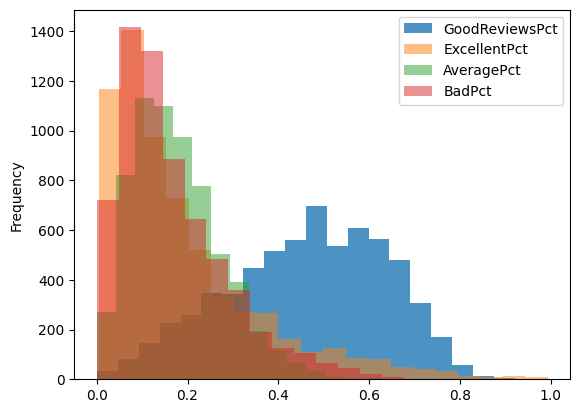

In [30]:
df['GoodReviewsPct'].plot.hist(bins=20, alpha=0.8)
df['ExcellentPct'].plot.hist(bins=20, alpha=0.5)
df['AveragePct'].plot.hist(bins=20, alpha=0.5)
df['BadPct'].plot.hist(bins=20, alpha=0.5)
plt.legend()

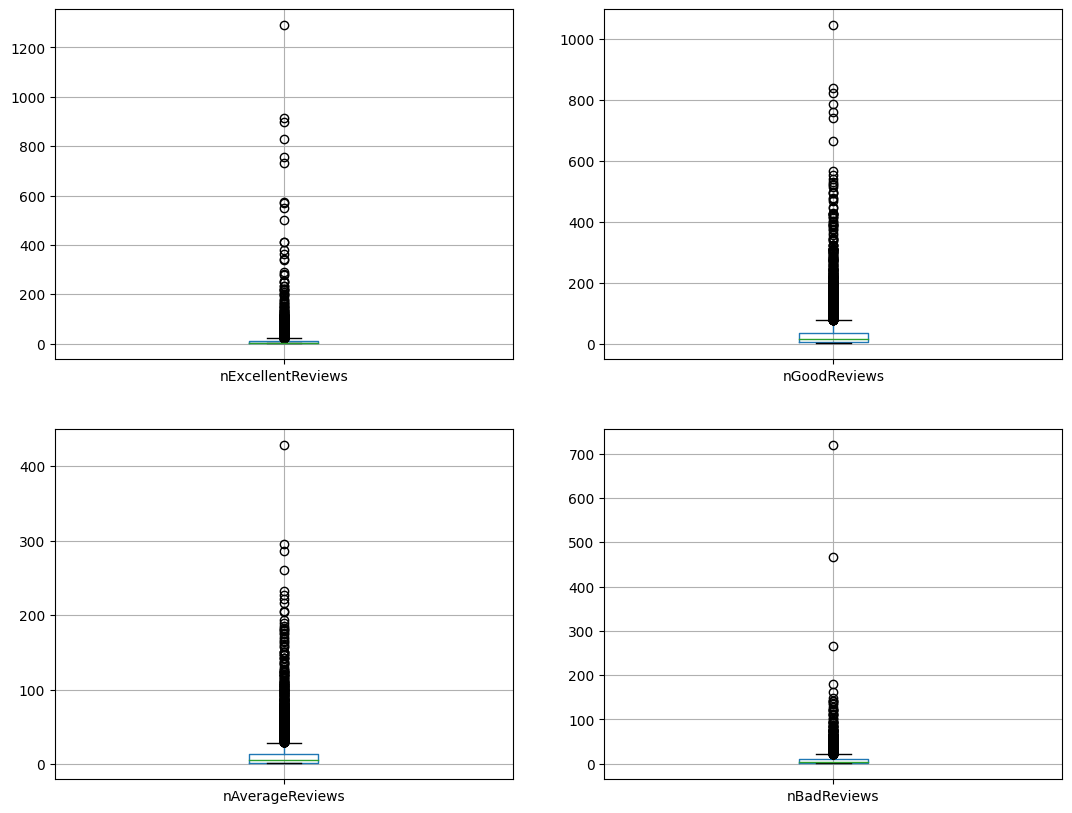

In [52]:
plt.figure(figsize=(13, 10))

# ['ExcellentPct', 'GoodReviewsPct', 'AveragePct', 'BadPct']
ls =  ['nExcellentReviews', 'nGoodReviews', 'nAverageReviews', 'nBadReviews']
for i, col in enumerate(ls, 1):
    ax = plt.subplot(2,2,i)
    df.boxplot(column=col, ax=ax)

- Khám phá data sau khi dc lọc:

In [53]:
n_dist = df['District'].nunique()
dist = df['District'].unique()

print(f"{df.shape[0]} quán trải cho {n_dist} quận:")
print(df.groupby('District')['RestaurantId'].count().sort_values())
df[['nExcellentReviews', 'nGoodReviews', 'nAverageReviews', 'nBadReviews']].agg([pd.Series.min, pd.Series.max])

6397 quán trải cho 24 quận:
District
Huyện Cần Giờ          1
Huyện Củ Chi           3
Huyện Nhà Bè          11
Quận 9                15
Huyện Hóc Môn         22
Huyện Bình Chánh      29
Quận 12               37
Quận 2                59
Quận Bình Tân         97
Quận 8                98
Quận 6               146
Quận 4               187
Quận 11              205
Quận Tân Phú         253
Quận 5               336
Tp. Thủ Đức          339
Quận 7               351
Quận Phú Nhuận       407
Quận Gò Vấp          411
Quận Tân Bình        523
Quận Bình Thạnh      550
Quận 10              600
Quận 3               636
Quận 1              1081
Name: RestaurantId, dtype: int64


,nExcellentReviews,nGoodReviews,nAverageReviews,nBadReviews
min,1.0,1.0,1.0,1.0
max,1290.0,1045.0,428.0,719.0


- Rút trích từ khoá cho từng hạng mục

In [31]:
cmt_ls = eval(data_hcm['Comment'][0])
cmt_body = [v for k,v  in cmt_ls.items()]
cmt_title = [k for k,v  in cmt_ls.items()]

In [39]:
print(f"SL review unique: {len(set(cmt_body))}/{len(cmt_body)}")
cmt_body = list(set(cmt_body))
cmt_body_0 = cmt_body[0]
cmt_body_0

SL review unique: 8/8


'SALE OFF 20%, 30%, 50%\nCần pass lại voucher F&B Nova.\n✅ Voucher ăn uống các loại 1tr, 2tr, 5tr, 10tr, 20tr. SALE OFF 20%, 30%, 50%\n✅ Giảm giá 50% tổng bill tại nhà hàng Jumbo seafood, Crystal Jade, Dynasty House.\n✅ Được ăn uống tất cả nhà hàng của hệ thống Nova F&B Nova.\n✅ Được dùng thêm nước uống có cồn.\n✅ Ace có nhu cầu liên hệ sdt 0938201000'

- Tiền xử lý văn bản

In [ ]:
underthesea

In [ ]:
cmt_body_0 = cmt_body_0.replace("\n", " ")
cmt_body_0 = cmt_body_0.lower()


cmt hiện chưa đủ 100 per restaurant nên ko ptích keyword dc

# 2. Trà sữa
Lý do: trà sữa là món phổ biến

In [3]:
menu = pd.read_csv('crawled_menu/menu.csv')
menu_dish = pd.read_csv('crawled_menu/menu_dish.csv')

In [60]:
##
data_hcm['ExtraInfo'][0]

'Có wifi, Có máy lạnh & điều hòa, Trả bằng thẻ, Có chỗ đậu ôtô, Nên đặt trước, Có bàn ngoài trời, Có phòng riêng, Có chỗ chơi cho trẻ em, Giữ xe máy miễn phí, Có xuất hóa đơn đỏ, Có hỗ trợ hội thảo'

In [4]:
dish_types = menu['dish_type_name']
ix_boba_tea = [ix for ix in dish_types.index if ('trà sữa' in dish_types[ix].lower()) or 
                                                ('milktea' in dish_types[ix].lower())]
boba_shops = menu.iloc[ix_boba_tea]
boba_shops.shape

(8859, 3)

In [5]:
df = pd.merge(boba_shops, menu_dish, on=['RestaurantID', 'dish_type_id'])
df.head()

,RestaurantID,dish_type_id,dish_type_name,dish_id,dish_name,dish_description,dish_price_value,dish_total_like,dish_is_available
0,1000048807,3403928.0,Combo Trà sữa + Bánh,67951791.0,Trà sữa chocolate sương sáo,NaN,60000.0,0,True
1,1000048807,3403928.0,Combo Trà sữa + Bánh,67951196.0,Trà sữa 3Q,NaN,60000.0,0,True
2,1000048807,3403928.0,Combo Trà sữa + Bánh,67951894.0,Trà nhài thơm xả,NaN,70000.0,0,True
3,1000048807,3403928.0,Combo Trà sữa + Bánh,67951740.0,Trà sữa Ô Lông hoàng kim,NaN,60000.0,0,True
4,1000048807,3403928.0,Combo Trà sữa + Bánh,67951177.0,Trà sữa Tc đen,"Bánh :tiramisu,mouse socola,mouse chanh dây. C...",60000.0,0,True


<AxesSubplot: ylabel='Frequency'>

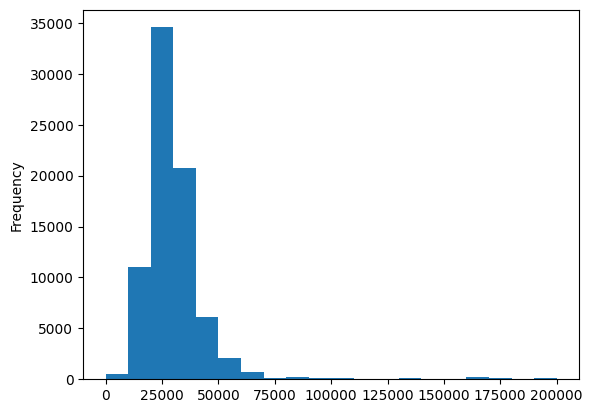

In [10]:
df['dish_price_value'].plot.hist(range=[0, 200000], bins=20)

In [21]:
list(df['dish_description'].dropna().unique())

['Bánh :tiramisu,mouse socola,mouse chanh dây. Chọn 1 trong 3 loại ',
 'Chưa có topping',
 'Đã có trân châu',
 'Thức uống đậm đà vị trà thái xanh, thơm béo vị sữa, có nhiều puding nhà làm an toàn, chất lượng.\nThực hiện đúng món và pudding như hình!',
 'Vị Xoài Thái lan, Thơm Ngon béo kết hợp Puding Xoài có sẵn, Phù Hợp Thêm Trân Châu Trắng.',
 'Đã bao gồm TCT giòn gụm, Vị Trà mạnh !',
 'Thức uống đậm đà vị trà taiwan, thơm béo vị sữa, có nhiều puding nhà làm an toàn, chất lượng.\nThực hiện đúng món và pudding như hình !',
 'Vị Khoai Môn,Thơm Béo, 10% Trà, Có Sẵn Puding Khoai Môn, Phù Hợp TCT Uống Kèm.',
 'Món mới, trà sữa taiwan bao gồm trân châu đen, với 1 bánh flan trứng tươi, không dùng chay được !',
 'Trà vị Đài Loan chỉ có Sẵn Trân Châu Đen, Thêm Puding Tuỳ Thích.',
 'Vị trà mới dịu dàng nhưng không kém phần đậm vị trà, thơm béo vừa, tỉnh táo sau khi uống ',
 'Vị Trà Đài Loan, Có Sẵn Tc Đen, Lớp Kem Phô Mai Trên Cùng Béo Ngậy.',
 'Thức uống đậm đà vị trà taiwan, đã bao gồm trân c

In [ ]:
boba_name = list(df['dish_name'])
not_boba = [item for item in boba_name if ('trà sữa' not in item.lower()) and 
                                          ('sữa tươi' not in item.lower()) and 
                                          ('TS' not in item.lower())]
not_boba

# 3. Phân bố địa lý những quán có promo_code

In [34]:
df_promo = data_hcm.dropna(subset='promo_code')
df_promo = df_promo[df_promo['promo_code'].apply(lambda x: len(x)) > 0]
df_promo['promo_code']

16       ['STB30', 'VIB50']
17       ['STB30', 'VIB50']
28       ['STB30', 'VIB50']
36       ['STB30', 'VIB50']
40       ['STB30', 'VIB50']
                ...        
93042                    []
93043                    []
93044                    []
93045                    []
93046                    []
Name: promo_code, Length: 54491, dtype: object